# FVI Clustering

This notebook filters frames based on FVI scores, creates embeddings for the selected frames, and clusters the embeddings.

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random


# Add the path to the scripts directory
import sys
sys.path.append('../scripts')
print(np.__version__)

1.26.4


## Load FVI Scores

Load the FVI scores from the `fvi_scores.json` file.

In [2]:
def load_fvi_scores(directory):
    fvi_scores = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'fvi_scores.json':
                filepath = os.path.join(root, file)
                with open(filepath, 'r') as f:
                    scores = json.load(f)
                    fvi_scores[root] = scores
    return fvi_scores

fvi_scores = load_fvi_scores('../output/fvi_computation')

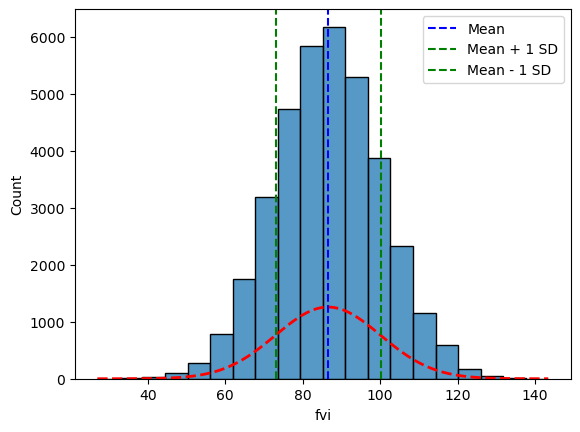

In [3]:
# create a chart to show the distribution of the fvi scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# Example fvi_scores dictionary for demonstration purposes
fvi_scores_list = []
for root, scores in fvi_scores.items():
    for score in scores:
        fvi_scores_list.append(score)

df = pd.DataFrame(fvi_scores_list, columns=['fvi'])

sns.histplot(df, x='fvi', bins=20)

# add a bell curve
mu, std = norm.fit(df['fvi'])
min_fvi, max_fvi = df['fvi'].min(), df['fvi'].max()
x = np.linspace(min_fvi, max_fvi, 100)
y = norm.pdf(x, mu, std) * len(df) * (x[1] - x[0])
plt.plot(x, y, 'r--', linewidth=2)

# Add standard deviation lines
plt.axvline(mu, color='blue', linestyle='--', label='Mean')
plt.axvline(mu + std, color='green', linestyle='--', label='Mean + 1 SD')
plt.axvline(mu - std, color='green', linestyle='--', label='Mean - 1 SD')
plt.legend()

plt.show()

## Filter Frames

Filter frames with FVI scores above a certain threshold.
low FVI scores => redundant

In [4]:
threshold = 60 # optimal threshold value not neglecting important frames
selected_frames_images = []
frame_ground_truth = []
for directory, scores in fvi_scores.items():
    for i, score in enumerate(scores):
        if score > threshold:
            directory = directory.replace("\\", "/")

            # Adjusting the directory path to replace "../output/ground_truth" with "/data"
            adjusted_directory = directory.replace("../output/fvi_computation", "../data/ground_truth")
            adjusted_directory_image = directory.replace("../output/fvi_computation", "../output/video_frames")

            # Adjusting the directory path to replace "/preds" with ""
            adjusted_directory_image = adjusted_directory_image.replace("preds", "")

            ground_truth_path = os.path.join(adjusted_directory, f'{i+1:04d}.json')
            image_path = os.path.join(adjusted_directory_image, f'{i+1:04d}.jpg')
            image_path = image_path.replace("\\", "/")
            ground_truth_path = ground_truth_path.replace("\\", "/")
            selected_frames_images.append(image_path)
            frame_ground_truth.append(ground_truth_path)

print(len(frame_ground_truth))
print(frame_ground_truth[:5])
print(selected_frames_images[:5])

35481
['../data/ground_truth/408/VID002C/preds/0001.json', '../data/ground_truth/408/VID002C/preds/0002.json', '../data/ground_truth/408/VID002C/preds/0003.json', '../data/ground_truth/408/VID002C/preds/0004.json', '../data/ground_truth/408/VID002C/preds/0005.json']
['../output/video_frames/408/VID002C/0001.jpg', '../output/video_frames/408/VID002C/0002.jpg', '../output/video_frames/408/VID002C/0003.jpg', '../output/video_frames/408/VID002C/0004.jpg', '../output/video_frames/408/VID002C/0005.jpg']


In [5]:
sys.path.append('../scripts')

from coco_converter import convert_selected_frames_to_coco

print(frame_ground_truth[:5]) # selected frame is actually the json groundtruth file.
convert_selected_frames_to_coco(frame_ground_truth, '../output/selected_frames_coco.json')

['../data/ground_truth/408/VID002C/preds/0001.json', '../data/ground_truth/408/VID002C/preds/0002.json', '../data/ground_truth/408/VID002C/preds/0003.json', '../data/ground_truth/408/VID002C/preds/0004.json', '../data/ground_truth/408/VID002C/preds/0005.json']
COCO file created at: ../output/selected_frames_coco.json


## Create Embeddings

Use a pre-trained ResNet model from PyTorch to create embeddings for the selected frames.

In [6]:
import torch
print(torch.cuda.is_available()) # run nvidia-smi to check if GPU is available

True


In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from sklearn.cluster import KMeans

sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import convert_selected_images_to_coco

/home/jayjpark/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jayjpark/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Generate Embeddings 

In [8]:
image_paths = selected_frames_images
# Generate embeddings for all images
embeddings = generate_embeddings(image_paths)
valid_embeddings = [embedding for embedding in embeddings if embedding is not None]  # Filter out None values in case error

# Find the optimal # of Clusters

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d147e4360>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d147e4360>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d13e672e0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d13e671a0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d13e672e0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d13e671a0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d147e4360>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766ec823c5e0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d147e4360>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766ec823c5e0>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766d147e4360>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

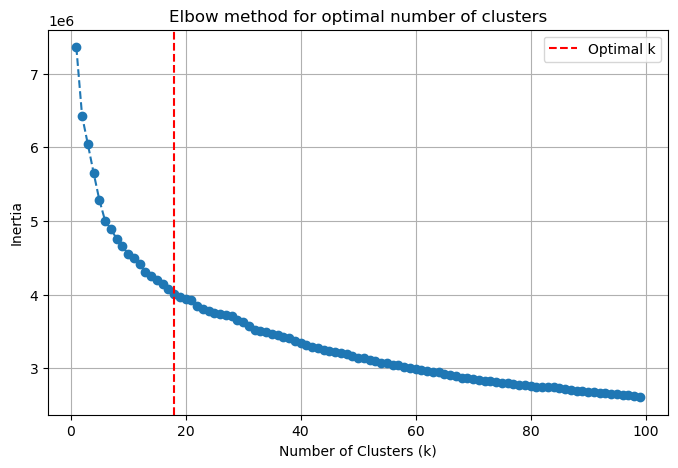

Optimal number of clusters: 18


In [9]:
from kneed import KneeLocator

# inertia 
k_values = range(1, 100)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(valid_embeddings)
    inertia_values.append(kmeans.inertia_)
    

knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(optimal_k, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()
print(f"Optimal number of clusters: {optimal_k}")


# Use the optimal number of clusters and for each cluster, calculate the centroid. Then get "m" many sample points per each cluster.

In [10]:
n_clusters = optimal_k  # of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(valid_embeddings)
clusters = kmeans.labels_

cluster_dict = []
for idx, cluster in enumerate(cluster_labels):
    cluster_dict.append({"cluster": cluster, "embedding": valid_embeddings[idx], "file_path": image_paths[idx]})

centroids = kmeans.cluster_centers_
m = 2 # of items to sample from each cluster that is closest to the centroid

# The sampled points that we want
closest_points = {}

for cluster_id, centroid in enumerate(centroids):
    distances = np.linalg.norm(embeddings - centroid, axis=1)
    closest_indices = np.argsort(distances)[:m]
    closest_points[cluster_id] = closest_indices
    

# Find the closest images to each centroid
representatives = []  # List to store representative images for each cluster

# Iterate over each cluster and find the closest points
for cluster_id, centroid in enumerate(centroids):
    # Compute distances from all valid embeddings to the centroid
    distances = np.linalg.norm(np.array(valid_embeddings) - centroid, axis=1)
    
    # Get indices of the closest images (m closest points)
    closest_indices = np.argsort(distances)[:m]
    
    # Create a dictionary for this cluster with image paths and embeddings
    cluster_representative = {
        "cluster": cluster_id,
        # "centroid": centroid.tolist(),  # Convert centroid to list for better readability
        "closest_images": [
            {
                "file_path": image_paths[idx],
                # "embedding": valid_embeddings[idx].tolist()  # Convert embedding to list
            }
            for idx in closest_indices
        ]
    }
    
    representatives.append(cluster_representative)


selected_representatives_images = [] # get the actual image paths
for rep in representatives:
    for path in rep["closest_images"]:
        selected_representatives_images.append(path['file_path'])

print(f"Number of selected representative images: {len(selected_representatives_images)}")

# Convert list to a dictionary with keys and values being the same
my_dict = {item: item for item in selected_representatives_images}

# Write the dictionary to a JSON file
with open('../output/selected_representatives_image.json', 'w') as json_file:
    json.dump(my_dict, json_file)

# Convert the selected representative images to COCO format
convert_selected_images_to_coco(selected_representatives_images, '../output/selected_representatives_coco.json')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x766ed4fa5760>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

Number of selected representative images: 36
[{'id': '../output/video_frames/408/VID002A/4737.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/408/VID002A/4737.jpg', 'metadata': 1001}, {'id': '../output/video_frames/408/VID002A/4731.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/408/VID002A/4731.jpg', 'metadata': 1001}, {'id': '../output/video_frames/PB/VID001B/1254.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/PB/VID001B/1254.jpg', 'metadata': 3}, {'id': '../output/video_frames/PB/VID001B/1251.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/PB/VID001B/1251.jpg', 'metadata': 1}, {'id': '../output/video_frames/496/VID001F/2603.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/496/VID001F/2603.jpg', 'metadata': 9}, {'id': '../output/video_frames/496/VID001F/1003.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/496/VID001F/1003.jpg', 'm

# Export sampled Image and Ground Truth 

In [16]:
selected_representatives_ground_truth = []
for image_path in selected_representatives_images:
    image_path = image_path.replace("output/video_frames", "data/ground_truth")
    # add /preds before the json
    path_parts = image_path.split('/')

    if len(path_parts) > 2:
        path_parts.insert(-1, 'preds')  # Insert 'preds' two positions before the end
    
    # Reconstruct the path with 'preds' included
    image_path_with_preds = '/'.join(path_parts)
    image_path = image_path_with_preds

    image_path = image_path.replace(".jpg", ".json")
    selected_representatives_ground_truth.append(image_path)

print(selected_representatives_ground_truth[:5])
print(selected_representatives_images[:5])

# export selected to /output/exported_data
import shutil

# Create the directory if it does not exist
output_dir = '../output/exported_data/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

export_file_name = n_clusters
    
# Copy the selected representative images to the output directory
for image in selected_representatives_images:
    image_path = image.split('/') # split the path to get the last part
    # join the path back excluding the last part
    image_path = (image_path[3:-1])
    image_path = F'../output/dataset_export/{threshold}_{n_clusters}_{m}/'+ '/'.join(image_path) + "/preds"
    if not os.path.exists(image_path):
        os.makedirs(image_path)
        print(f"Created directory: {image_path}")
    
    shutil.copy(image, image_path)

# Copy the selected representative ground truth files to the output directory
for gt in selected_representatives_ground_truth:
    gt_path = gt.split('/') # split the path to get the last part
    # join the path back excluding the last part
    gt_path = (gt_path[3:-1])
    gt_path = F'../output/dataset_export/{threshold}_{n_clusters}_{m}/'+ '/'.join(gt_path)
    if not os.path.exists(gt_path):
        os.makedirs(gt_path)
        print(f"Created directory: {gt_path}")
    
    shutil.copy(gt, gt_path)

['../data/ground_truth/408/VID002A/preds/4737.json', '../data/ground_truth/408/VID002A/preds/4731.json', '../data/ground_truth/PB/VID001B/preds/1254.json', '../data/ground_truth/PB/VID001B/preds/1251.json', '../data/ground_truth/496/VID001F/preds/2603.json']
['../output/video_frames/408/VID002A/4737.jpg', '../output/video_frames/408/VID002A/4731.jpg', '../output/video_frames/PB/VID001B/1254.jpg', '../output/video_frames/PB/VID001B/1251.jpg', '../output/video_frames/496/VID001F/2603.jpg']
Created directory: ../output/dataset_export/60_18_2/408/VID002A/preds
Created directory: ../output/dataset_export/60_18_2/PB/VID001B/preds
Created directory: ../output/dataset_export/60_18_2/496/VID001F/preds
Created directory: ../output/dataset_export/60_18_2/417/VID003A/preds
Created directory: ../output/dataset_export/60_18_2/432/VID001B/preds
Created directory: ../output/dataset_export/60_18_2/432/VID001C/preds
Created directory: ../output/dataset_export/60_18_2/PB/VID001A/preds
Created directory: 

# Export Filtered Coco File and Images from Dataset 

In [12]:
import fiftyone as fo
import fiftyone.brain as fob


from coco_converter import categories # import coco categories for detection

# Define the directory where you want to export the dataset
export_dir = "../output/selected_representatives_dataset"

# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)


# Export the dataset to COCO format
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    categories=categories
)

# Export the dataset to the specified directory
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageDirectory
)


 100% |███████████████████| 36/36 [1.2s elapsed, 0s remaining, 29.6 samples/s]         
Directory '../output/selected_representatives_dataset' already exists; export will be merged with existing files
Found multiple fields ['detections', 'segmentations'] with compatible type (<class 'fiftyone.core.labels.Detections'>, <class 'fiftyone.core.labels.Polylines'>, <class 'fiftyone.core.labels.Keypoints'>); exporting 'detections'
 100% |███████████████████| 36/36 [229.1ms elapsed, 0s remaining, 157.1 samples/s]      
Directory '../output/selected_representatives_dataset' already exists; export will be merged with existing files
 100% |███████████████████| 36/36 [218.9ms elapsed, 0s remaining, 164.5 samples/s]     


# View filtered dataset

In [13]:
# View the dataset in Fiftyone and visualize the data + embeddings
fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="umap",
    brain_key="umap_resnet101",
    patches_field="detections"
)

session = fo.launch_app(dataset)
session.wait()

Computing patch embeddings...
 100% |███████████████████| 36/36 [7.3s elapsed, 0s remaining, 5.3 samples/s]      
Generating visualization...
UMAP( verbose=True)
Mon Dec 16 15:20:17 2024 Construct fuzzy simplicial set
Mon Dec 16 15:20:17 2024 Finding Nearest Neighbors
Mon Dec 16 15:20:19 2024 Finished Nearest Neighbor Search
Mon Dec 16 15:20:21 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Dec 16 15:20:22 2024 Finished embedding


Notebook sessions cannot wait
